## Training with a Neural Network
This notebook contains the training of a Keras Sequential model on insider data, which attempts to predict the maximum 90-day percentage gain of a ticker whose insider(s) made a trade. We use a single dense hidden layer and a dropout layer, and we use the Keras Tuner to choose an optimal learning rate and number of hidden units.

In [1]:
%load_ext autoreload
%autoreload 1
%aimport my_functions

import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, ReLU
from tensorflow.keras.activations import linear
from tensorflow.keras.regularizers import L2
from operator import itemgetter

from my_functions import *

pd.options.mode.chained_assignment = None
plt.style.use('fivethirtyeight')

In [2]:
'''
Read in the trade data and prepare it for modeling.
'''

DAYS_TO_LOOK_BACK = 5  # used for calculating volume volatility and recent-trade counts
BIN_STARTS = [0, 1, 10]  # these are the boundaries between output-oversampling intervals

train_cv_test_set = my_model_prep.prepareForModel(pd.read_csv('../data/training_cv_test.csv'))

testStartDate = max(train_cv_test_set.FilingDate) - dt.timedelta(days=14)
train_cv_set = train_cv_test_set.loc[train_cv_test_set.FilingDate < testStartDate]
test_set = train_cv_test_set.loc[train_cv_test_set.FilingDate >= testStartDate]
test_set.to_csv('../data/test.csv')

train_set, cv_set = train_test_split(train_cv_set, test_size=0.05, shuffle=True, random_state=42)

trainStartDate = min(train_set.FilingDate) + dt.timedelta(days=DAYS_TO_LOOK_BACK)
train_XY, train_X, train_Y = my_model_prep.returnXandY(
    train_set.loc[train_set.FilingDate > trainStartDate], binStarts=BIN_STARTS
)

cv_XY, cv_X, cv_Y = my_model_prep.returnXandY(cv_set, binStarts=BIN_STARTS)

In [3]:
print(f'Train shape: {train_X.shape}')
print(f'CV shape: {cv_X.shape}')

Train shape: (20994, 11)
CV shape: (1080, 11)


In [4]:
# We'll need this later.
def plotLearningCurves(history, losses):
    '''
    Plot the Keras training and cross-validation learning curves for each loss.
    
    IN:
        history (History object obtained from a Keras fit)
        losses (List[str]): contains name of each validation metric
    '''
    fig, axs = plt.subplots(1, len(losses), figsize=(6.4*len(losses), 4.8))
    if type(axs) != np.ndarray: axs = [axs]
        
    for i, name in enumerate(losses):
        trainingLoss = history.history[name]
        cvLoss = history.history['val_' + name]
        epochs = range(1, len(trainingLoss) + 1)
        
        axs[i].plot(epochs, trainingLoss, label='train')
        axs[i].plot(epochs, cvLoss, label='cv')
        axs[i].set_xlabel('Epoch')
        axs[i].set_ylabel('Loss')
        axs[i].set_title('Learning Curve: ' + name)
        axs[i].legend()

    plt.show()

In [5]:
'''
Perform standard feature normalization.
'''
scaler = StandardScaler().fit(train_X)
train_X_scaled = scaler.transform(train_X)
cv_X_scaled = scaler.transform(cv_X)

Here is a StackExchange answer that provides a starting point for deciding on the number of hidden units to include: https://stats.stackexchange.com/a/136542

### Below is a computation to obtain the absolute maximum number of hidden units:

In [6]:
Ns = train_X_scaled.shape[0]  # training examples
No = 1                           # output neurons
Ni = train_X_scaled.shape[1]  # input neurons
alpha = 5                # scale factor

Nh = Ns / (alpha*(Ni + No))      # maximum hidden neurons

print(f'An upper bound for number of hidden units: {int(Nh)}')

An upper bound for number of hidden units: 349


This seems like *quite* a lot; we certainly don't need this many hidden units! 

### However, we can remove some of the guesswork by using Keras Tuner. 
With this tool, we can search the parameter space and also determine an optimal number of hidden units.

We have 10 inputs. Let's opt for one Dense hidden layer with
- 16-64 hidden units,
- kernel regularizer = 0.01 (to prevent weight blowup),
- gradient clipping for norms greater than 1 (to prevent gradient explosion),
- Adam optimizer with learning rate between 0.0001 and 0.0005,
- our custom loss (explained in decision_tree) for both the objective and evaluation metric.

In [7]:
from tensorflow.python.ops import math_ops, numpy_ops
numpy_ops.np_config.enable_numpy_behavior()

def asymm_rmse(y_true, y_pred):
    '''
    A custom rmse loss function that penalizes overestimated losses by 4x and underestimated gains by 2x.
    '''
    isOverestimatedLoss = ((y_true < y_pred) & (y_true < 0.1)).astype(float)
    isUnderestimatedGain = ((y_true > y_pred) & (y_true > 10)).astype(float)
    
    diff = (4*isOverestimatedLoss + 2*isUnderestimatedGain + 1)*math_ops.squared_difference(y_pred, y_true)

    loss = tf.math.sqrt(tf.reduce_mean(diff, axis=-1))

    return loss

In [8]:
import keras_tuner as kt
from tensorflow.keras.backend import maximum, minimum

tf.random.set_seed(40)

def model_builder(numFeatures):
    def builder(tuner):
        numUnits = tuner.Int('units', min_value=16, max_value=64, step=8)
        learningRate = tuner.Choice('learningRate', values=[5e-4, 1e-4])
                
        model = Sequential(
            [               
                Input(shape=(numFeatures,)),
                Dense(units=numUnits, activation='relu', kernel_regularizer=L2(0.01)),
                #Dropout(0.5),
                #Dense(units=numUnits/4, activation='relu', kernel_regularizer=L2(1e-3)),
                Dense(units=1, activation='linear'),
                ReLU(max_value=25.),
            ], name = 'nn_model' 
        )

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=learningRate, clipnorm=1.0),
            loss=asymm_rmse,
            metrics=asymm_rmse
        )

        return model
    return builder

BayesianOptimization is an algorithm that efficiently searches the hyperparameter space. 

We use EarlyStopping to halt training early if there is no loss improvement in the 10 most recent epochs.

In [9]:
tuner = kt.BayesianOptimization(
    model_builder(train_X_scaled.shape[1]),
    objective=kt.Objective('asymm_rmse', 'min'),
    max_trials=6,
    overwrite=True,
    directory='tuner logs',
    project_name='asymm_rmse'
)

tuner.search(
    train_X_scaled, train_Y, 
    epochs=20,
    batch_size=32,
    validation_data=(cv_X_scaled, cv_Y),
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)]
)

Trial 6 Complete [00h 00m 27s]
asymm_rmse: 8.51883602142334

Best asymm_rmse So Far: 8.507502555847168
Total elapsed time: 00h 02m 48s
INFO:tensorflow:Oracle triggered exit


In [10]:
best_hparams = tuner.get_best_hyperparameters()[0]

print(f'These are the best hyperparameter values: \n {best_hparams.values}')

These are the best hyperparameter values: 
 {'units': 64, 'learningRate': 0.0005}


In [17]:
'''
Let's build the model with the best parameters and use it to make predictions on the training and CV sets.
'''
nn_model = tuner.hypermodel.build(best_hparams)
history = nn_model.fit(train_X_scaled, train_Y, epochs=50, batch_size=32, validation_data=(cv_X_scaled, cv_Y))
train_Y_preds = nn_model.predict(train_X_scaled)
cv_Y_preds = nn_model.predict(cv_X_scaled)

Epoch 1/50
657/657 [==============================] - 1s 992us/step - loss: 10.1833 - asymm_rmse: 10.0753 - val_loss: 9.2893 - val_asymm_rmse: 9.1927
Epoch 2/50
657/657 [==============================] - 1s 886us/step - loss: 9.0415 - asymm_rmse: 8.9345 - val_loss: 8.5146 - val_asymm_rmse: 8.4046
Epoch 3/50
657/657 [==============================] - 1s 875us/step - loss: 8.8145 - asymm_rmse: 8.7056 - val_loss: 8.2793 - val_asymm_rmse: 8.1752
Epoch 4/50
657/657 [==============================] - 1s 887us/step - loss: 8.7662 - asymm_rmse: 8.6651 - val_loss: 8.2089 - val_asymm_rmse: 8.1138
Epoch 5/50
657/657 [==============================] - 1s 864us/step - loss: 8.7383 - asymm_rmse: 8.6458 - val_loss: 8.1227 - val_asymm_rmse: 8.0320
Epoch 6/50
657/657 [==============================] - 1s 863us/step - loss: 8.7160 - asymm_rmse: 8.6274 - val_loss: 8.0516 - val_asymm_rmse: 7.9665
Epoch 7/50
657/657 [==============================] - 1s 865us/step - loss: 8.6985 - asymm_rmse: 8.6155 - val_

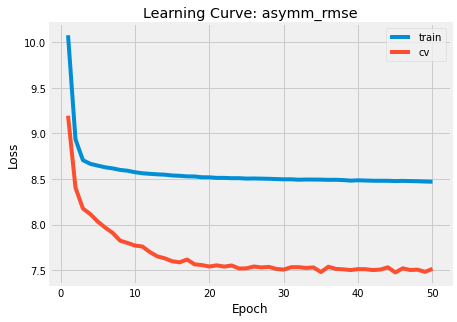

In [18]:
plotLearningCurves(history, ['asymm_rmse'])

Interesting... it seems like the training set has a lot of examples that are hard for the NN to learn.

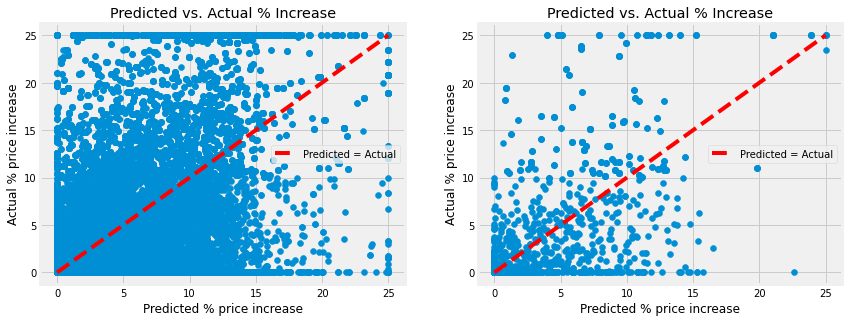

In [19]:
my_plots.plotPredictedVsActual(train_Y_preds, train_Y, cv_Y_preds, cv_Y)

Training on the left; CV on the right.

Training leaves A LOT to be desired. There is a significant number of overestimated losses, and tons of high-gainers that are predicted to be losses. CV performance isn't too impressive either. 

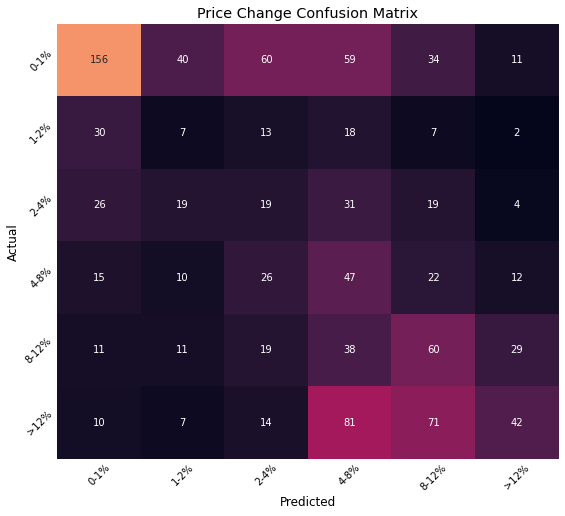

In [20]:
my_plots.confusionMatrix(cv_Y_preds, cv_Y.to_numpy(), intervalBounds=[0,1,2,4,8,12], maxNumInCat=200)

### The XGBoost model will be more helpful for profit purposes.

What we see above is actually relatively similar to the XGBoost output, but XGBoost is better at identifying large gains >12%. Not to mention that the XGBoost model actually seemed to learn from the training set, whereas the NN model leaves a lot more to be desired in this regard.

In [15]:
nn_model.save('models/nn_model')

INFO:tensorflow:Assets written to: models/nn_model\assets


In [ ]:
#cv_XY_saved = my_misc.load_obj('../data/cv_XY')
#cv_XY_saved['NN_Prediction'] = cv_Y_preds
#my_misc.save_obj(cv_XY_saved, '../data/cv_XY')